<a href="https://colab.research.google.com/github/venk-meg/STRIKE/blob/main/CNN%20Initial/Gesture_CNNmodel_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN Gesture Classification Version 1**

This version is to test the classification accuracy and whether the microprocessor effectively handles the weight of the CNN model (which gets saved as a tensorflow lite model to reduce size and latency).

## What does the code do?
- Clones STRIKE repo, imports necessary libraries
- Creates a label map (pre-defined)
- Add_labels_to_columns() function: The label column did not exist in initial CSV recorded data files for all gestures except rest. This function adds label column for all such files. Won't be needed in the future as all recorded files will  have the label column.
- Data cleaning & transformation:
  - Drop rows that contains strings (besides the 1st column header row)
  - Add label column
  - ensuring all entries are numeric
- load_gesture_data() function:
  - Initializes lists X (features) and y (labels).
  - For each gesture:
    - Loads all CSV files from its folder.
    - Skips empty files.
    - Drops timestamp column if present.
    - Keeps only numeric columns.
    - Verifies and collects the gesture label from the label column
    - Pads or truncates data to fixed shape: 217 timesteps × 19 features. **Note:** The timesteps are currently hardcoded as 217. The logic follows as: With a constant sampling rate (25Hz) and number of samples (10), each recorded CSV has approx 2177 rows. To parse the CSV for each take/repeat, we divide 2177/10 = 217.7, rounded down to 217 to avoid indexing problems (i.e. if we round up to 218, and if the dataset size is 2177, the take no. 10's CSV file would be having 3 less rows compared to the rest of the takes). As CNNs require same length samples, we account for these situations by padding rows with 0s, or truncating them. In the future, we plan to remove the hardcoded, assumed 217 and solve uneven sample length issues with padding/truncating.

  - Converts X to a 3D NumPy array (samples × time × features).
  - Converts y to categorical (using one-hot encoding).
  - Splits the dataset into training and test sets (70/30 split), using stratified sampling.
  - Replaces any NaN or Inf values in the dataset with 0s.

- Creates a 1D convolutional neural network with:
  - Two Conv1D + MaxPooling1D + BatchNorm blocks.
  - One dense layer with dropout.
  - Final softmax layer for multi-class classification.
  - Compiles with Adam optimizer and categorical crossentropy loss.
  - Trains the model on the training set with early stopping (patience = 5).

- Model Evaluation
  - Makes predictions on the test set.
  - Prints classification report (precision, recall, f1-score).
  - Plots a confusion matrix showing how often each gesture was correctly classified

## Next Steps for the code

- remove print statements that were included for debugging
- remove hardcoded timestep
- remove repetition of coverting cols data type to numeric
- optimize:
  - file processing --> currently processes and reads each file
    - processing time for ~ 210 gesture files + 40 rest files is ~ 45 seconds
  - reduce if-else statements



fatal: destination path 'STRIKE' already exists and is not an empty directory.
/content/STRIKE
Processing file: data_ml/slice/slice_06_R.csv
  - Cleaned and saved data_ml/slice/slice_06_R.csv
Processing file: data_ml/slice/slice_10_DW.csv
  - Cleaned and saved data_ml/slice/slice_10_DW.csv
Processing file: data_ml/slice/slice_05_DW.csv
  - Cleaned and saved data_ml/slice/slice_05_DW.csv
Processing file: data_ml/slice/slice_10.csv
  - Cleaned and saved data_ml/slice/slice_10.csv
Processing file: data_ml/slice/slice_02_DW.csv
  - Cleaned and saved data_ml/slice/slice_02_DW.csv
Processing file: data_ml/slice/slice_10_R.csv
  - Cleaned and saved data_ml/slice/slice_10_R.csv
Processing file: data_ml/slice/slice_07.csv
  - Cleaned and saved data_ml/slice/slice_07.csv
Processing file: data_ml/slice/slice_05.csv
  - Cleaned and saved data_ml/slice/slice_05.csv
Processing file: data_ml/slice/trial_slice_10x_25hz_R.csv
  - Cleaned and saved data_ml/slice/trial_slice_10x_25hz_R.csv
Processing fil

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.4196 - loss: 2.9456 - val_accuracy: 0.3000 - val_loss: 11.2001
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8258 - loss: 0.9496 - val_accuracy: 0.4500 - val_loss: 5.6417
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9215 - loss: 0.5447 - val_accuracy: 0.6625 - val_loss: 2.5429
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9153 - loss: 0.5700 - val_accuracy: 0.6875 - val_loss: 1.3647
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9605 - loss: 0.1726 - val_accuracy: 0.7375 - val_loss: 1.6570
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9523 - loss: 0.3257 - val_accuracy: 0.8875 - val_loss: 0.6558
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9447 - loss: 0.1946 - val_accuracy: 0.8500 - val_loss: 0.7955
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9398 - loss: 0.2834 - val_accuracy: 0.8875 - 

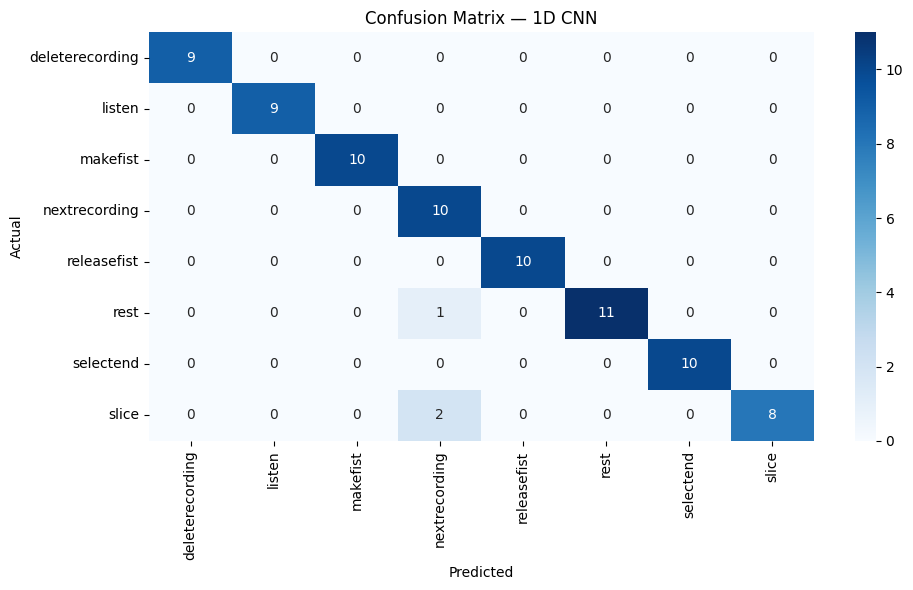

In [1]:
# Clone repo if not already cloned
!git clone https://github.com/venk-meg/STRIKE.git
%cd STRIKE

import pandas as pd
import glob
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from collections import Counter
import zipfile

# Define the label-to-gesture mapping (same as before)
gesture_mapping = {
    1: 'makefist',
    2: 'releasefist',
    3: 'listen',
    4: 'nextrecording',
    6: 'deleterecording',
    7: 'slice',
    8: 'selectend',
    12: 'rest'
}

def add_labels_to_gesture_files():
    data_dir = 'data_ml'

    for gesture in os.listdir(data_dir):
        gesture_path = os.path.join(data_dir, gesture)
        if not os.path.isdir(gesture_path):
            continue  # Skip non-directory entries

        # Get label (skip 'rest' which already has it)
        if gesture == 'rest':
            gesture_label = 12  # Keep rest as-is, it already has labels
        else:
            gesture_label = list(gesture_mapping.keys())[list(gesture_mapping.values()).index(gesture)]

        gesture_files = glob.glob(f"{gesture_path}/*.csv")
        gesture_files = [f for f in gesture_files if not f.endswith('.gitkeep')]

        for file in gesture_files:
            print(f"Processing file: {file}")
            df = pd.read_csv(file)

            # Drop second row if it contains any strings
            if len(df) > 1 and df.iloc[1].apply(lambda x: isinstance(x, str)).any():
                df = df.drop(index=1).reset_index(drop=True)
                print(f"  - Dropped second row from {file} due to string content.")

            # Add label if not already present
            if 'label' not in df.columns:
                df['label'] = gesture_label

            # Convert numeric columns to numbers
            for col in df.columns:
                if col != 'label':
                    df[col] = pd.to_numeric(df[col], errors='coerce')

            df.to_csv(file, index=False)
            print(f"  - Cleaned and saved {file}")

# Call the function to add labels to all gesture files (except 'rest')
add_labels_to_gesture_files()

def load_gesture_data():
    X = []
    y = []

    # Define the expected number of features (columns), update to 19 as per your data
    expected_columns = 19  # Update to 19 based on your data

    # Define the label to gesture mapping
    gesture_mapping = {
        1: 'makefist',
        2: 'releasefist',
        3: 'listen',
        4: 'nextrecording',
        6: 'deleterecording',
        7: 'slice',
        8: 'selectend',
        12: 'rest'
    }

    # Load data for each gesture
    for gesture in gesture_mapping.values():
        gesture_path = os.path.join('data_ml', gesture)

        # Get all CSV files in the folder
        gesture_files = glob.glob(f"{gesture_path}/*.csv")  # Get all CSVs in the folder
        gesture_files = [f for f in gesture_files if not f.endswith('.gitkeep')]  # Skip .gitkeep files

        # Debugging: Print number of files being processed
        print(f"Processing {len(gesture_files)} files for gesture: {gesture}")

        for file in gesture_files:
            print(f"Reading file: {file}")

            # Check if the file is empty before processing it
            if os.stat(file).st_size == 0:
                print(f"Skipping empty file: {file}")
                continue

            df = pd.read_csv(file)

            # Drop timestamp if it exists
            if 'timestamp' in df.columns:
                df = df.drop(columns=['timestamp'])

            # Drop non-numeric columns (keep only numeric ones)
            df = df.select_dtypes(include=[np.number])  # Keep only numeric columns

            # Check if the label column exists and process accordingly
            if 'label' in df.columns:
                labels = df['label'].unique()  # Get unique labels in the current file

                # Check if the label matches the expected one and map it
                for label in labels:
                    if label in gesture_mapping:
                        # Correctly map the label to its gesture name
                        gesture_name = gesture_mapping[label]
                        y.append(gesture_name)  # Append the gesture name to `y`
                    else:
                        print(f"Warning: Label {label} in file {file} doesn't match any known gesture.")

                # Drop the 'label' column since we don't need it for the input
                df = df.drop(columns=['label'])

            # Check the number of columns in the file
            if df.shape[1] != expected_columns:
                print(f"Warning: File {file} has {df.shape[1]} columns, expected {expected_columns} columns. Padding/truncating columns.")

                # If the number of columns is less than expected, pad with zeros
                if df.shape[1] < expected_columns:
                    padding = np.zeros((df.shape[0], expected_columns - df.shape[1]))  # Pad columns
                    df = np.hstack([df, padding])
                # If the number of columns is greater than expected, truncate to the expected size
                elif df.shape[1] > expected_columns:
                    df = df.iloc[:, :expected_columns]  # Truncate to expected columns

            # Convert DataFrame to NumPy array only once
            data = df.values  # Use df.values instead of df.to_numpy()

            # Ensure each sample has the same number of timesteps (217)
            if data.shape[0] < 217:
                padding = np.zeros((217 - data.shape[0], data.shape[1]))  # Pad rows
                data = np.vstack([data, padding])
            elif data.shape[0] > 217:
                data = data[:217, :]  # Truncate rows to 217 timesteps

            X.append(data)

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Encode labels (with "rest" as a gesture)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)

    # Check class distribution before splitting
    print(f"Class distribution before train-test split: {dict(Counter(np.argmax(y_categorical, axis=1)))}")

    # Split data into train and test sets (with stratification)
    X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.3, stratify=y_encoded, random_state=42)

    # Convert X_train and X_test to float32
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    # Check the data types again after conversion
    print(f"X_train dtype (after conversion): {X_train.dtype}")
    print(f"X_test dtype (after conversion): {X_test.dtype}")

    # Check for NaN or Inf in X_train and X_test
    print(f"Any NaN in X_train: {np.any(np.isnan(X_train))}")
    print(f"Any NaN in X_test: {np.any(np.isnan(X_test))}")
    print(f"Any Inf in X_train: {np.any(np.isinf(X_train))}")
    print(f"Any Inf in X_test: {np.any(np.isinf(X_test))}")

    # If NaNs or Infs are present, replace them with 0 or appropriate values
    X_train = np.nan_to_num(X_train)
    X_test = np.nan_to_num(X_test)

    # Check class distribution after splitting
    print(f"Class distribution in training set: {dict(Counter(np.argmax(y_train, axis=1)))}")
    print(f"Class distribution in test set: {dict(Counter(np.argmax(y_test, axis=1)))}")

    return X_train, X_test, y_train, y_test, label_encoder

# Prepare data
X_train, X_test, y_train, y_test, label_encoder = load_gesture_data()

# Build 1D CNN Model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling1D(2),
    BatchNormalization(),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')  # Softmax for multi-class classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=8,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Report
print("\n📄 Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — 1D CNN")
plt.tight_layout()
plt.show()


## Model Evaluation Analysis (GPT answer)

📈 Key observations
Most classes have perfect or near-perfect precision and recall, indicating your model distinguishes them very well.

- The lowest recall classes are "slice" (0.80) and "rest" (0.92), meaning some true instances of these classes are missed.

- "nextrecording" has slightly lower precision (0.77), so some other gestures are misclassified as "nextrecording".

- The weighted and macro averages are high (~0.96-0.97), showing consistent model performance across classes despite minor imperfections.


💡 Recommendations
- Focus on improving recall for "slice" and "rest" to reduce missed gestures.

- Investigate why "nextrecording" suffers from false positives — possibly add more training samples or refine features.

- If you want to boost recall, consider techniques like class-specific data augmentation or threshold tuning.




## Saving trained model as a tensorflow lite model

In [2]:
import tensorflow as tf

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optimize for size (8-bit quantization)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# You can optionally specify representative data if needed
# but for most use cases on microcontrollers, DEFAULT works

tflite_model = converter.convert()

# Save the TFLite model to file
tflite_model_path = "gesture_cnn_v1.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"\n✅ Saved TensorFlow Lite model to: {tflite_model_path}")


Saved artifact at '/tmp/tmpjt5tkkco'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 217, 19), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  133330702093968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133330702095312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133330702094736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133330702097808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133330702097040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133330702097616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133330702098960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133330702099536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133330702099728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133330702098576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133330702097424: T

## Convert .tflite to C array (for Arduino)

In [3]:
# File paths
tflite_path = "gesture_cnn_v1.tflite"
cc_path = "gesture_cnn_v1.cc"
h_path = "gesture_cnn_v1.h"

# Read TFLite model
with open(tflite_path, "rb") as f:
    data = f.read()

# Format hex array with line breaks (12 bytes per line)
hex_lines = []
line = []
for i, b in enumerate(data):
    line.append(f'0x{b:02x}')
    if (i + 1) % 12 == 0:
        hex_lines.append(', '.join(line))
        line = []
if line:
    hex_lines.append(', '.join(line))

# Write .cc file
with open(cc_path, "w") as f:
    f.write('#include <cstdint>\n')
    f.write('#include "gesture_cnn_v1.h"\n\n')
    f.write('alignas(16) const unsigned char gesture_cnn_v1_tflite[] = {\n')
    for l in hex_lines:
        f.write(f'  {l},\n')
    f.write('};\n\n')
    f.write(f'const unsigned int gesture_cnn_v1_tflite_len = {len(data)};\n')

# Write .h file
with open(h_path, "w") as f:
    f.write('#ifndef GESTURE_CNN_V1_H_\n')
    f.write('#define GESTURE_CNN_V1_H_\n\n')
    f.write('#include <cstdint>\n\n')
    f.write('extern const unsigned char gesture_cnn_v1_tflite[];\n')
    f.write('extern const unsigned int gesture_cnn_v1_tflite_len;\n\n')
    f.write('#endif  // GESTURE_CNN_V1_H_\n')

# Download files
from google.colab import files
files.download(tflite_path)
files.download(cc_path)
files.download(h_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>